#Try Stock Prediction - Amazon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import joblib
import yfinance as yf
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## 1. Read Data

In [2]:
# stock_data = pd.read_csv('/content/NFLX.csv', index_col='Date')
# stock_data

ticker = 'AMZN'
# start_date = '2020-05-20'
# end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = '2020-05-21'
end_date = '2024-05-21'
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-21,125.000000,126.272499,122.126999,122.336998,122.336998,102288000
2020-05-22,122.750504,123.492500,121.506500,121.844002,121.844002,57342000
2020-05-26,122.900002,123.099998,120.703003,121.093002,121.093002,71364000
2020-05-27,120.249496,120.679001,116.500000,120.519501,120.519501,101138000
2020-05-28,119.216499,121.848503,118.911499,120.055000,120.055000,63804000
...,...,...,...,...,...,...
2024-05-14,183.820007,187.720001,183.449997,187.070007,187.070007,38698200
2024-05-15,185.970001,186.720001,182.729996,185.990005,185.990005,75459900
2024-05-16,185.600006,187.309998,183.460007,183.630005,183.630005,38834500


## 2. Plotting Data

### 2.1 Plot High & Low

In [3]:
# Define function to create input and output sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Hyperparameters
seq_length = 7
n_features = stock_data.shape[1]
n_units = 64
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 32
epochs = 50

### 2.2 Plot Open & Close

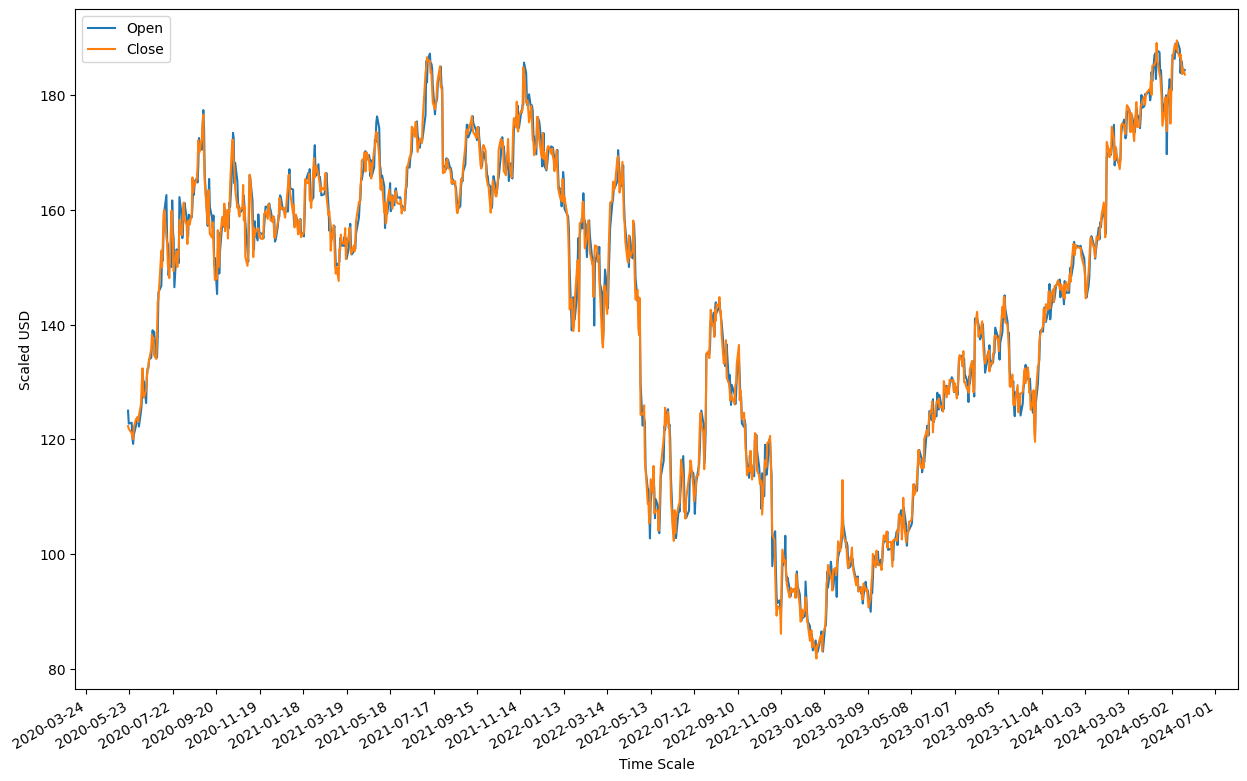

In [4]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
# x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
x_dates = stock_data.index

plt.plot(x_dates, stock_data['Open'], label='Open')
plt.plot(x_dates, stock_data['Close'], label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## 3. Stock Prediction

### 3.1 Normalize or Rescale

In [5]:
features = stock_data.iloc[:, 0:4]
sc = StandardScaler()
features_scaled = sc.fit_transform(features.values)
stock_data_ft = pd.DataFrame(columns=features.columns, data=features_scaled, index=features.index)

# Simpan objek StandardScaler
joblib.dump(sc, 'standard_scaler.pkl')


['standard_scaler.pkl']

### 3.2 Train & Test

#### 3.2.1 Splitting

In [6]:
def lstm_split(data, n_steps):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [7]:
n_steps = 6
X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[n_steps-1:split_idx + n_steps-1], date_index[split_idx + n_steps-1:len(X1) + n_steps-1]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(1000, 6, 3) (800, 6, 3) (200, 6, 3) (200,)


#### 3.2.2 Training

In [8]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
lstm.add(Dropout(0.4))
lstm.add(LSTM(50, activation='tanh'))
lstm.add(Dropout(0.2))
lstm.add(Dense(30, activation = 'relu'))
lstm.add(Dense(30, activation = 'relu'))
lstm.add(Dense(1, activation = 'linear'))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             10800     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 30)                1530      
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [10]:
history = lstm.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=2, verbose = 1, shuffle=True, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
320/320 [==============================] - 7s 10ms/step - loss: 0.1023 - val_loss: 0.2000
Epoch 2/200
 19/320 [>.............................] - ETA: 1s - loss: 0.0493

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 2s 7ms/step - loss: 0.0510 - val_loss: 0.0811
Epoch 3/200
320/320 [==============================] - 2s 8ms/step - loss: 0.0416 - val_loss: 0.0173
Epoch 4/200
320/320 [==============================] - 3s 10ms/step - loss: 0.0350 - val_loss: 0.0194
Epoch 5/200
320/320 [==============================] - 2s 7ms/step - loss: 0.0335 - val_loss: 0.0079
Epoch 6/200
320/320 [==============================] - 2s 7ms/step - loss: 0.0288 - val_loss: 0.0061
Epoch 7/200
320/320 [==============================] - 2s 7ms/step - loss: 0.0222 - val_loss: 0.0058
Epoch 8/200
320/320 [==============================] - 2s 7ms/step - loss: 0.0253 - val_loss: 0.0546
Epoch 9/200
320/320 [==============================] - 3s 10ms/step - loss: 0.0241 - val_loss: 0.0055
Epoch 10/200
320/320 [==============================] - 3s 9ms/step - loss: 0.0224 - val_loss: 0.1159
Epoch 11/200
320/320 [==============================] - 2s 7ms/step - loss: 0.0193 - val_loss: 0.005

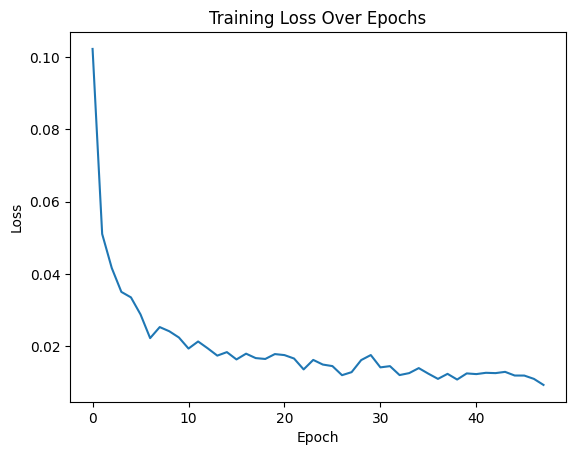

In [11]:
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 3.2.3 Evaluation

7/7 [==============================] - 1s 4ms/step


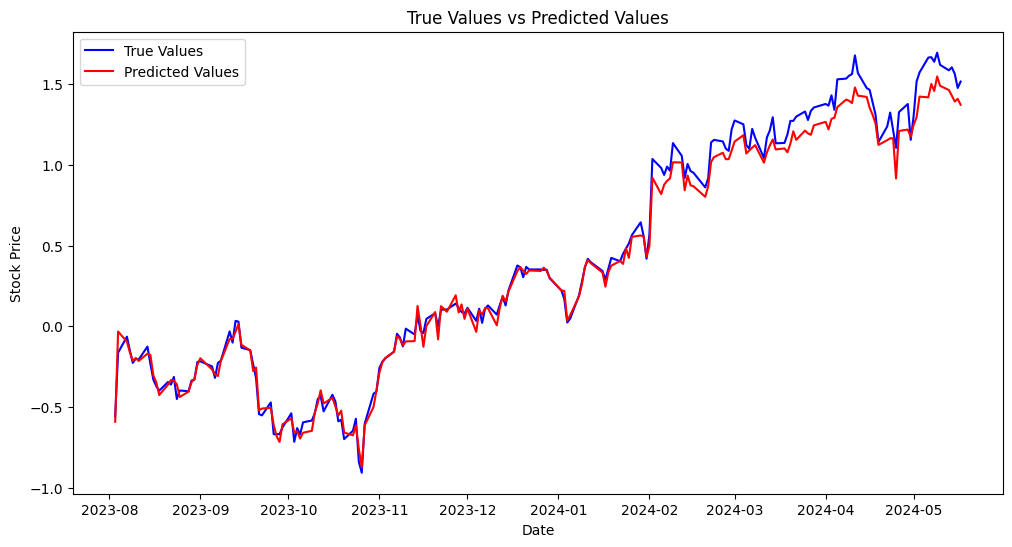

In [12]:
# Make predictions
y_pred = lstm.predict(X_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_test_date, y_test, label='True Values', color='blue')
plt.plot(X_test_date, y_pred, label='Predicted Values', color='red')
plt.title('True Values vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [13]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.07869783772013875
MAPE:  0.4573818794018216


In [14]:
# Save Model
lstm.save("predict_amzn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.2.4 Compare Performance

In [15]:
n_steps_list = [2, 6, 13, 20]
results = []
models = []

for n_steps in n_steps_list:
    X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

    split_idx = int(np.ceil(len(X1) * 0.8))
    X_train, X_test = X1[:split_idx], X1[split_idx:]
    y_train, y_test = y1[:split_idx], y1[split_idx:]

    lstm = Sequential()
    lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(50, activation='tanh'))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    lstm.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

    y_pred = lstm.predict(X_test)
    y_pred = y_pred.flatten()  # Ensure y_pred is a 1D array

    #sc_y.fit(y_train.reshape(-1, 1))  # Fit scaler on training target data
    #y_pred = sc_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    #y_test = sc_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append((n_steps, rmse, mape))
    models.append(lstm)

Epoch 1/100
201/201 - 4s - loss: 0.0866 - 4s/epoch - 21ms/step
Epoch 2/100
201/201 - 1s - loss: 0.0298 - 705ms/epoch - 4ms/step
Epoch 3/100
201/201 - 1s - loss: 0.0245 - 672ms/epoch - 3ms/step
Epoch 4/100
201/201 - 1s - loss: 0.0306 - 720ms/epoch - 4ms/step
Epoch 5/100
201/201 - 1s - loss: 0.0269 - 684ms/epoch - 3ms/step
Epoch 6/100
201/201 - 1s - loss: 0.0262 - 819ms/epoch - 4ms/step
Epoch 7/100
201/201 - 1s - loss: 0.0258 - 1s/epoch - 5ms/step
Epoch 8/100
201/201 - 1s - loss: 0.0230 - 1s/epoch - 5ms/step
Epoch 9/100
201/201 - 1s - loss: 0.0224 - 1s/epoch - 5ms/step
Epoch 10/100
201/201 - 1s - loss: 0.0230 - 681ms/epoch - 3ms/step
Epoch 11/100
201/201 - 1s - loss: 0.0264 - 706ms/epoch - 4ms/step
Epoch 12/100
201/201 - 1s - loss: 0.0210 - 724ms/epoch - 4ms/step
Epoch 13/100
201/201 - 1s - loss: 0.0207 - 712ms/epoch - 4ms/step
Epoch 14/100
201/201 - 1s - loss: 0.0188 - 693ms/epoch - 3ms/step
Epoch 15/100
201/201 - 1s - loss: 0.0209 - 724ms/epoch - 4ms/step
Epoch 16/100
201/201 - 1s - lo

In [16]:
for result in results:
    print(f"n_steps: {result[0]}, RMSE: {result[1]}, MAPE: {result[2]}")

n_steps: 2, RMSE: 0.05276606848928921, MAPE: 0.3394357495275226
n_steps: 6, RMSE: 0.10914517156702469, MAPE: 0.5137273733938152
n_steps: 13, RMSE: 0.08060163677301929, MAPE: 0.38028764760452954
n_steps: 20, RMSE: 0.05614421380448427, MAPE: 0.3903382008793588


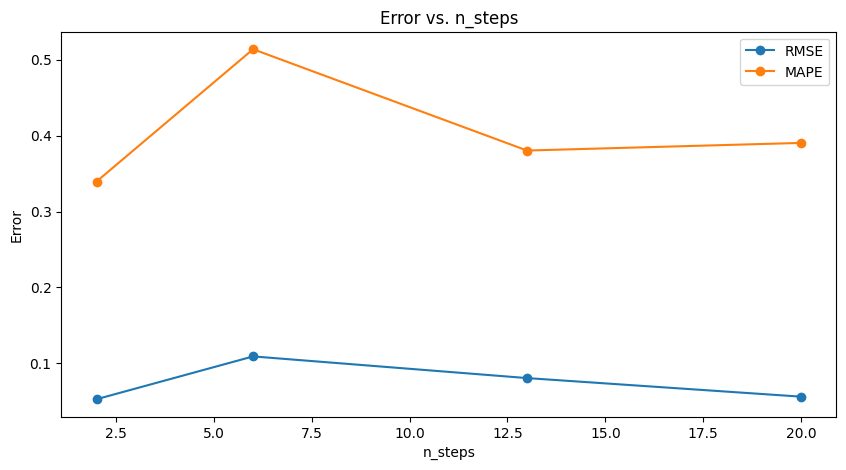

In [17]:
plt.figure(figsize=(10, 5))
plt.plot([result[0] for result in results], [result[1] for result in results], marker='o', label='RMSE')
plt.plot([result[0] for result in results], [result[2] for result in results], marker='o', label='MAPE')
plt.xlabel('n_steps')
plt.ylabel('Error')
plt.title('Error vs. n_steps')
plt.legend()
plt.show()

The result shows that n_steps = n will reach the most accurate prediction, means that predicting the n+1th days is the best choice

#### 3.2.5 Cross Validation

In [ ]:
# n_steps = 6
# X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5)
# rmse_scores = []
# mape_scores = []

# for train_index, test_index in tscv.split(X1):
#     X_train, X_test = X1[train_index], X1[test_index]
#     y_train, y_test = y1[train_index], y1[test_index]

#     # Define the model
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
#     model.add(LSTM(50, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     # Train the model
#     model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, shuffle=False)

#     # Predict
#     y_pred = model.predict(X_test)
#     y_pred = y_pred[:, 0]

#     # Calculate RMSE and MAPE
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     mape = mean_absolute_percentage_error(y_test, y_pred)

#     rmse_scores.append(rmse)
#     mape_scores.append(mape)

# print(f"Average RMSE: {np.mean(rmse_scores)}, Average MAPE: {np.mean(mape_scores)}")

###3.3 Run Saved Model

In [18]:
# Load the SavedModel
model = tf.keras.models.load_model('predict_amzn.h5')
sc = joblib.load('standard_scaler.pkl')

In [19]:
def prepare_input_data(ticker, end_date, n_steps):
    stock_data = yf.download(ticker, end=end_date)
    X_feat = stock_data[['Open', 'High', 'Low']]
    target_y = stock_data['Close']

    X_ft = sc.fit_transform(X_feat.values)
    stock_data_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)
    stock_data_ft['Close'] = target_y.values

    input_data = stock_data_ft.values[-n_steps:, :-1]
    input_data = np.expand_dims(input_data, axis=0)

    return input_data, stock_data_ft.index[-1]

In [20]:
# Parameter prediksi
ticker = 'AMZN'
end_date = '2024-05-31'
n_steps = 6

# Menyiapkan data input
input_data, last_date = prepare_input_data(ticker, end_date, n_steps)

# Melakukan prediksi
predicted_price_scaled = model.predict(input_data).flatten()[0]

# Mengembalikan hasil prediksi ke skala semula
predicted_price = sc.inverse_transform([[np.nan, predicted_price_scaled, np.nan]])[0][1]

# Menampilkan hasil prediksi
print(f"Harga saham {ticker} yang diprediksi untuk tanggal {end_date} adalah: {predicted_price:.2f}")

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 1s 842ms/step
Harga saham AMZN yang diprediksi untuk tanggal 2024-05-31 adalah: 173.79
